In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnb import *

In [4]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'D1', 'SP1', 'I1', 'F1']
df = df[(df.Div.isin(div)) & (df.Season >= 16) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
procs = [Categorify, FillMissing, Normalize]

In [10]:
valid_idx = list(df.query('Season == 21').index)

In [11]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [12]:
splits

((#9010) [0,1,2,3,4,5,6,7,8,9...],
 (#1105) [1528,1529,1530,1531,1532,1533,1534,1535,1536,1537...])

In [13]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [14]:
y_block = RegressionBlock(n_out=2)

In [15]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
6550,I1,Cagliari,Udinese,2.0,1.0,12.0,7.0,3.0,1.0,7.0,...,14,5,104,False,False,False,False,False,False,1.523664e+09
7217,I1,Sampdoria,Napoli,2.0,4.0,12.0,12.0,10.0,10.0,4.0,...,3,0,34,False,False,False,False,False,False,1.580688e+09
1384,D1,Stuttgart,Mainz,2.0,0.0,9.0,10.0,3.0,2.0,2.0,...,29,4,29,False,False,False,False,False,False,1.611878e+09
186,D1,M'gladbach,RB Leipzig,1.0,2.0,12.0,9.0,3.0,5.0,8.0,...,19,6,50,False,False,False,False,False,False,1.487462e+09
2219,E0,Liverpool,Chelsea,1.0,1.0,16.0,11.0,4.0,3.0,7.0,...,25,5,329,False,False,False,False,False,False,1.511568e+09
6924,I1,Lazio,Sassuolo,2.0,2.0,18.0,3.0,7.0,2.0,11.0,...,7,6,97,False,False,False,False,False,False,1.554595e+09
4148,F1,Metz,Lyon,0.0,3.0,15.0,18.0,3.0,6.0,7.0,...,5,2,95,False,False,False,False,False,False,1.491350e+09
9898,SP1,Betis,Cadiz,1.0,1.0,16.0,8.0,7.0,3.0,4.0,...,20,4,232,False,False,False,False,False,False,1.629418e+09
7222,I1,Verona,Juventus,2.0,1.0,9.0,10.0,5.0,5.0,3.0,...,8,5,39,False,False,False,False,False,False,1.581120e+09
8502,SP1,Sevilla,La Coruna,2.0,0.0,10.0,11.0,6.0,3.0,6.0,...,2,5,336,False,False,False,False,False,False,1.512173e+09


In [16]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [17]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#24) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [18]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg
10113,5,134,117,0.063624,-0.28726,-0.439663,0.474147,-0.371807,0.016347,0.109383,0.673868,0.631563,-0.269710,-0.012171,0.339608,-1.183622,-0.481617,-0.478623,0.403814,1.972377,1.375774,1.129117,-0.267161,0.394046,-0.115852,-0.294266,-1.038985
10114,5,7,42,-0.481669,0.16212,-0.567149,0.855544,-0.371807,0.163604,-0.181815,-0.818017,0.335328,0.006117,-0.561802,0.618255,-0.015065,-0.413650,-0.207141,0.540765,-0.654528,1.580765,0.088350,0.145023,1.729991,-0.532552,-0.143402,-0.900397


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [19]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [20]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [21]:
X_train.shape, y_train.shape

((9010, 27), (9010, 2))

In [22]:
X_test.shape, y_test.shape

((1105, 27), (1105, 2))

## LightGBM

In [23]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [24]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [25]:
import lightgbm as lgbm

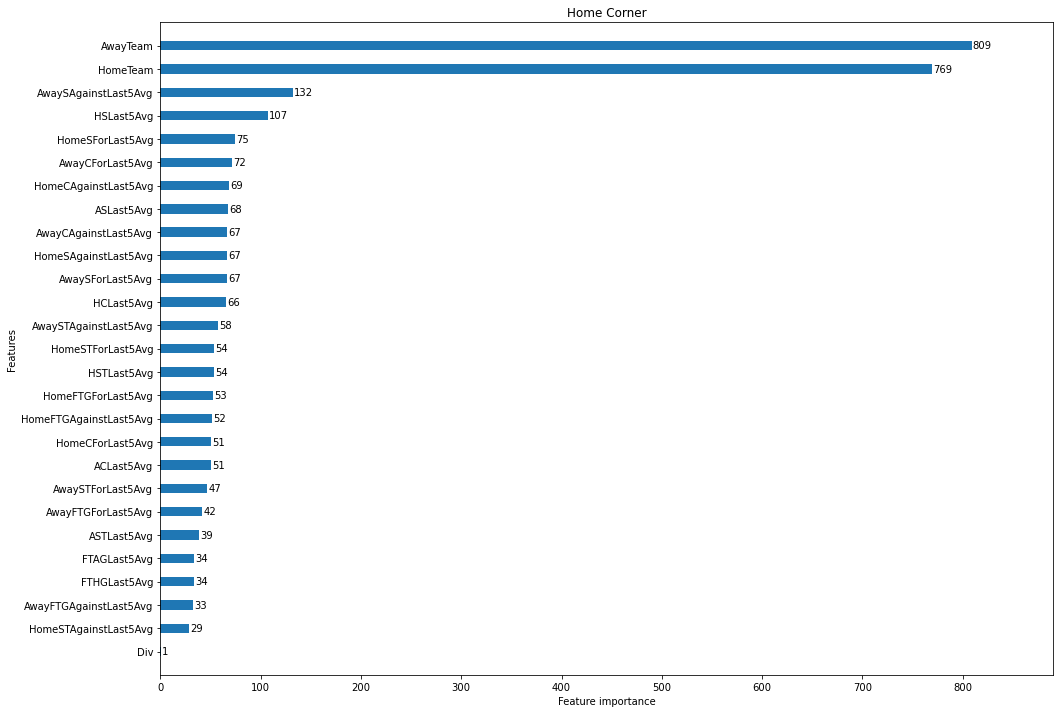

In [26]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

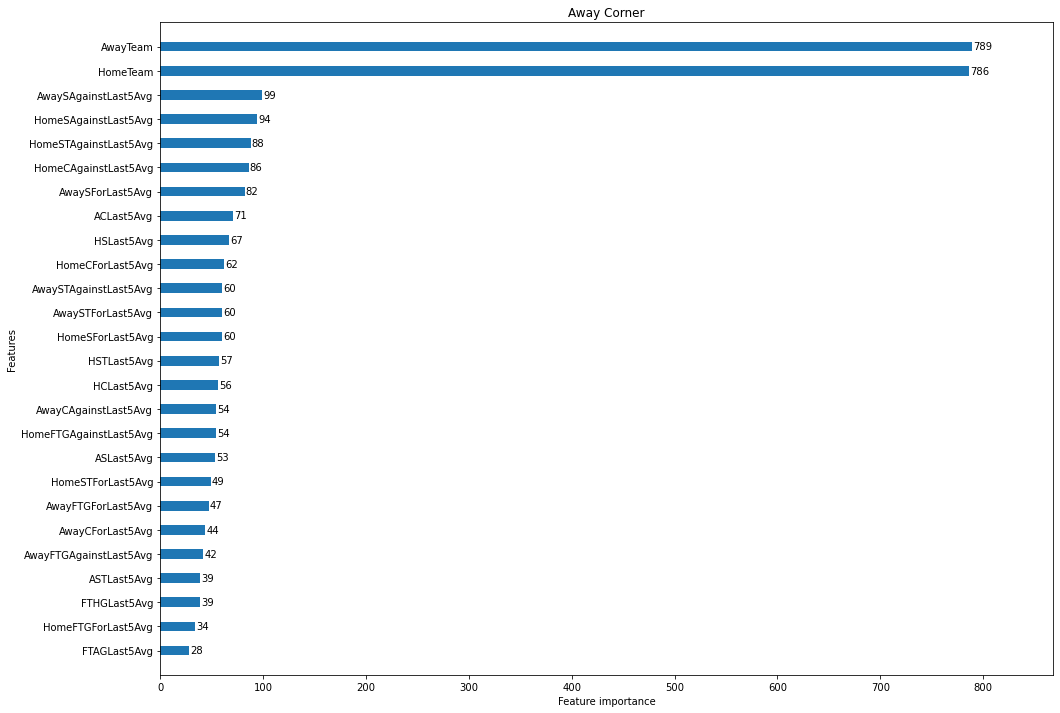

In [27]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [28]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [29]:
import xgboost as xgb

In [30]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

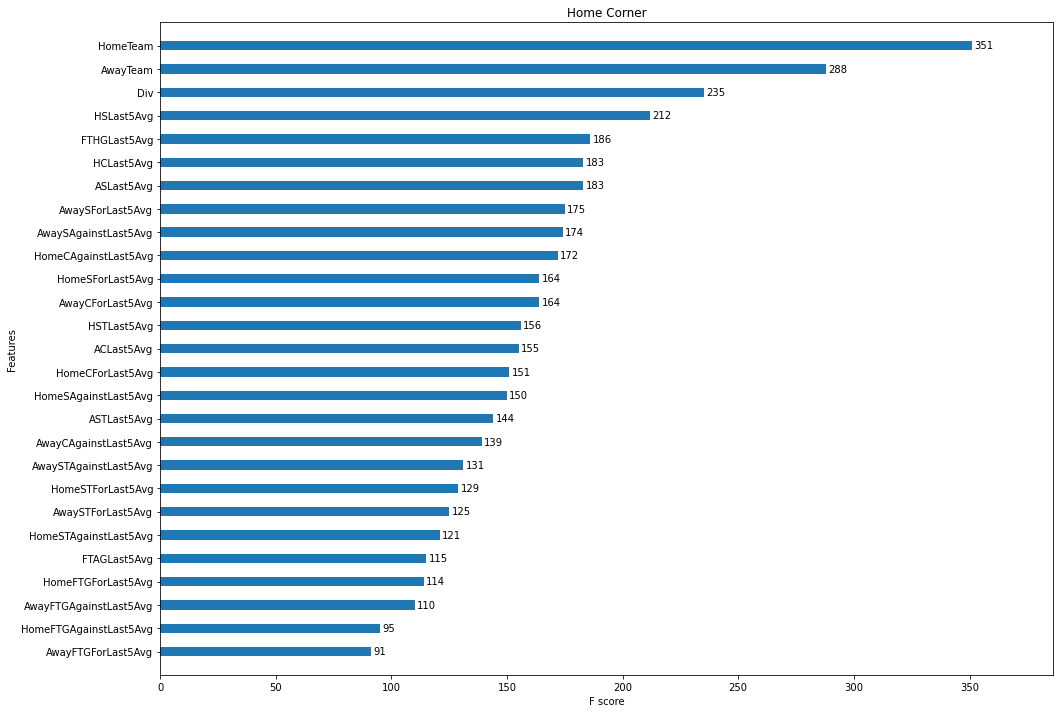

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

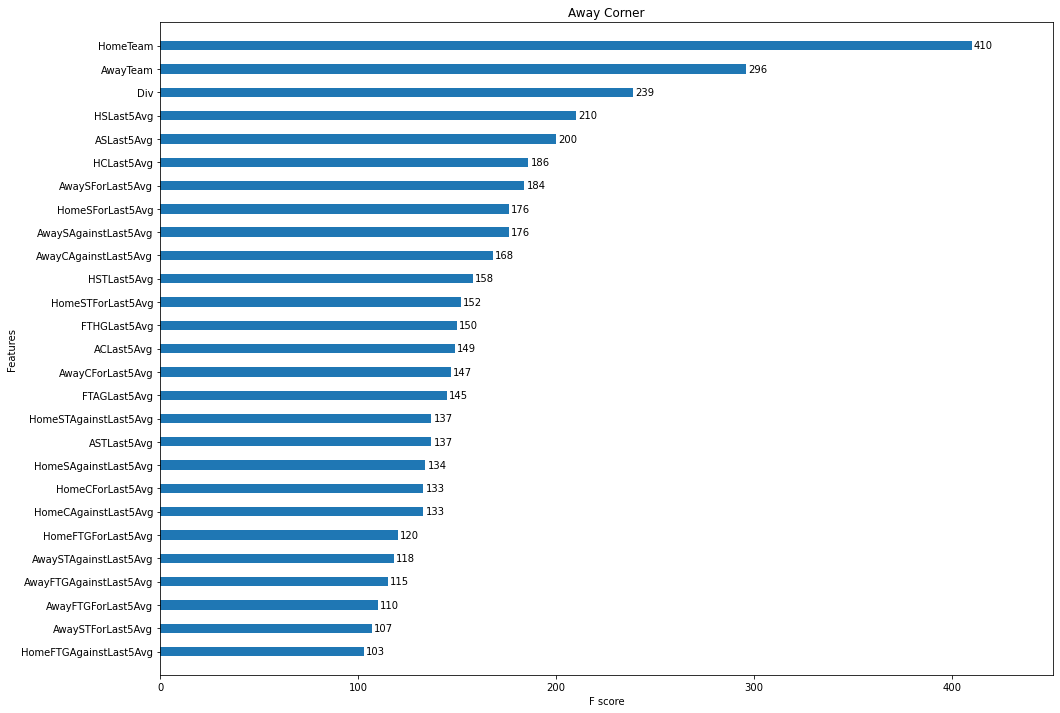

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [33]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,I1,Spal,Udinese,1.0,9.2,4.6,6.0,0.8,10.6,4.2,5.4,0.6,10.6,4.4,4.8,0.6,6.4,1.6,1.200000,1.2,10.800000,6.6,4.6,1.0,15.4,5.2,9.4,7.0,2.0
1,E0,Man United,Swansea,1.2,17.4,5.4,6.6,0.4,8.2,2.2,3.4,1.6,12.0,4.4,3.8,0.6,9.2,3.0,6.400000,0.2,10.400000,2.8,4.4,1.0,12.8,5.0,4.8,5.0,2.0
2,I1,Milan,Udinese,0.6,12.2,7.6,6.6,1.2,7.6,3.6,5.0,1.0,10.8,7.2,4.8,1.6,8.6,4.6,5.400000,1.4,9.400000,5.6,4.2,1.0,11.8,5.6,7.6,9.0,3.0
3,SP1,Osasuna,Las Palmas,0.6,14.2,6.0,7.4,1.8,9.0,4.8,3.0,0.8,11.0,4.4,6.4,2.0,8.8,5.0,2.600000,2.4,13.000000,5.4,3.6,1.8,16.6,5.8,5.6,1.0,12.0
4,I1,Inter,Lazio,2.4,23.0,7.6,10.0,2.6,13.0,4.2,6.0,1.8,19.0,6.0,10.4,2.2,15.8,5.4,8.399999,1.0,11.600000,5.0,3.2,1.6,14.2,5.0,4.0,10.0,8.0
5,F1,Montpellier,Toulouse,1.6,13.2,4.2,4.8,0.2,8.6,3.8,3.8,1.4,13.2,3.8,5.4,0.2,7.8,2.8,3.800000,2.4,10.400000,5.0,4.6,1.0,13.2,4.0,5.6,5.0,8.0
6,SP1,Barcelona,Granada,3.6,14.0,7.8,4.2,0.6,10.2,2.0,3.4,2.6,13.0,7.0,4.6,1.0,11.6,2.6,5.000000,1.4,11.600000,3.6,5.2,1.4,14.0,5.0,4.2,7.0,0.0
7,F1,Lille,Metz,1.4,13.6,3.8,4.6,0.6,8.4,3.4,2.6,1.6,15.6,5.0,4.4,1.4,8.4,3.8,3.200000,0.8,12.800000,5.2,5.0,2.8,15.0,5.6,5.4,11.0,2.0
8,SP1,Espanol,Vallecano,1.0,13.6,4.6,4.6,0.4,11.8,3.4,5.4,1.4,13.8,2.2,2.2,1.8,12.0,5.2,4.600000,2.4,13.000000,5.8,5.6,1.2,12.8,3.6,7.2,6.0,2.0
9,E0,Bournemouth,Hull,1.0,11.6,3.4,6.8,1.2,10.0,3.2,6.4,1.0,10.2,2.6,5.8,0.6,7.0,2.2,3.800000,1.4,17.200001,5.6,5.4,2.6,24.0,8.2,7.0,5.0,4.0


In [34]:
learn = tabular_learner(dls, layers=[240, 120])

In [35]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(146, 26)
    (2): Embedding(146, 26)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=80, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [36]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.0020892962347716093)

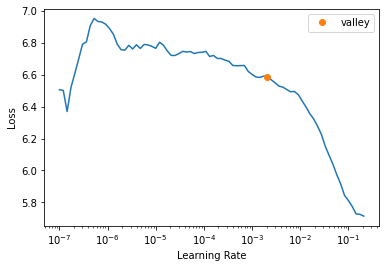

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,2.836667,2.484760,00:01
1,2.447812,2.407217,00:01
2,2.375869,2.358713,00:01
3,2.343018,2.358960,00:01
4,2.300344,2.357225,00:01


In [39]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3626,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [40]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [41]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [42]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.9093) tensor(3.9093)
tensor(5.9712) tensor(5.9712)


In [43]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [44]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [45]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [46]:
prob_lo, prob_hi

(tensor(0.5980), tensor(0.4020))

## Negative Binomial

In [47]:
y_block = RegressionBlock(n_out=4)

In [48]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [49]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,SP1,Sociedad,Levante,1.6,11.400000,3.2,5.2,0.8,10.2,2.8,5.8,1.0,11.600000,2.6,4.6,1.0,11.8,3.4,6.2,1.400000e+00,11.6,4.8,4.2,1.6,15.2,4.8,3.6,5.0,3.0
1,D1,Dortmund,M'gladbach,2.6,20.400000,7.0,7.2,2.0,12.4,4.2,2.6,2.6,19.400000,6.2,5.4,1.4,14.2,4.0,4.8,5.373336e-08,6.6,2.0,3.2,1.0,14.0,4.8,4.4,7.0,0.0
2,I1,Torino,Milan,2.2,10.400000,5.6,6.6,1.0,10.0,4.8,6.0,1.8,8.400000,4.2,6.2,1.0,10.2,4.6,4.4,1.400000e+00,12.6,7.2,6.6,1.0,7.8,4.6,5.6,3.0,5.0
3,F1,Montpellier,Metz,1.8,13.800000,4.6,6.2,1.2,9.0,3.6,3.4,2.2,14.600000,4.8,5.4,1.0,11.4,4.4,5.2,1.600000e+00,10.6,3.6,3.4,1.8,15.4,4.6,5.6,10.0,2.0
4,I1,Atalanta,Udinese,1.2,15.600000,4.4,6.0,0.4,10.2,2.0,3.8,1.6,14.600000,4.6,6.6,0.4,10.4,2.2,3.2,8.000000e-01,11.4,2.0,4.2,2.0,13.8,4.8,6.2,10.0,6.0
5,SP1,Alaves,Girona,0.6,10.600000,3.2,6.2,0.6,7.8,2.2,2.8,0.8,11.400000,3.4,5.8,0.6,9.6,2.6,4.2,1.800000e+00,12.4,4.0,6.4,1.4,10.4,5.0,3.6,6.0,4.0
6,SP1,Espanol,Sevilla,1.8,8.800000,3.2,4.0,0.8,11.6,3.4,6.4,1.8,11.600000,4.4,4.6,1.6,10.8,5.0,4.6,4.000000e-01,13.8,4.0,5.4,1.0,11.2,3.4,3.8,8.0,4.0
7,I1,Cagliari,Spal,1.2,9.200000,4.4,6.4,1.2,9.0,3.6,4.8,1.8,7.000000,3.4,2.4,0.8,9.4,4.4,6.8,8.000000e-01,13.2,6.2,8.0,1.8,11.8,6.4,6.8,6.0,6.0
8,E0,Man City,Fulham,3.2,21.799999,8.6,6.6,1.6,14.4,5.2,3.8,2.4,20.799999,7.6,8.8,1.6,14.6,6.2,3.6,6.000000e-01,7.2,2.2,2.2,2.4,14.6,6.8,4.8,10.0,4.0
9,F1,Montpellier,Caen,1.0,15.000000,5.2,4.6,1.2,12.4,3.6,3.0,0.2,13.200000,4.2,5.6,0.6,12.8,3.8,8.0,2.200000e+00,14.4,5.8,3.6,1.8,13.2,6.6,3.6,9.0,3.0


In [50]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=4)

In [51]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(146, 26)
    (2): Embedding(146, 26)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=80, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=4, bias=True)
    )
  )
)

In [52]:
learn_bnb.loss_func = BivariateNegativeBinomialNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialNLLLoss(
  (softmax_probs): Softmax(dim=-1)
  (softplus_total_count): Softplus(beta=1, threshold=20)
)

SuggestedLRs(valley=0.005011872388422489)

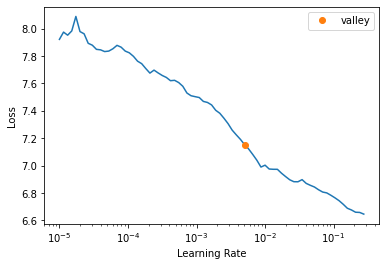

In [53]:
learn_bnb.lr_find(start_lr=1e-05)

In [54]:
learn_bnb.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,5.392511,5.058382,00:01
1,4.990990,4.942085,00:01
2,4.799758,4.833827,00:01
3,4.718987,4.773550,00:01
4,4.658748,4.741478,00:01


In [55]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3626,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [56]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [57]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [58]:
probs = F.softmax(params[0:3], dim=-1)
alpha = F.softplus(params[3])
total_count = 1 / alpha
print(probs, total_count)

bnb_corner = BivariateNegativeBinomial(total_count=total_count, probs=probs)

tensor([0.7607, 0.0896, 0.1497]) tensor(30.3573)


In [59]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([30.3573,  3.5763,  5.9742]) tensor([60.7146,  3.9976,  7.1498])


In [60]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [61]:
corner = bnb_corner.log_prob(value).exp()

In [62]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [63]:
prob_lo, prob_hi

(tensor(0.6328), tensor(0.3672))

In [64]:
1/prob_lo, 1/prob_hi

(tensor(1.5803), tensor(2.7232))

### Train full model

In [65]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [66]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,E0,Swansea,Southampton,1.8,14.400000,5.8,6.4,0.6,15.6,4.6,7.8,1.2,11.4,4.4,4.6,1.0,14.2,3.6,6.4,2.8,12.4,5.4,3.8,2.0,12.2,3.8,5.4,5.0,4.0
1,SP1,Las Palmas,Ath Bilbao,1.4,12.000000,6.0,5.0,1.0,8.2,2.8,3.6,1.0,12.6,5.8,5.8,1.2,11.8,4.6,5.8,1.4,10.2,4.0,3.0,1.0,9.8,3.8,4.4,5.0,3.0
2,D1,RB Leipzig,Stuttgart,2.4,16.400000,5.6,4.0,0.6,11.4,3.8,3.6,1.8,14.2,5.4,3.2,0.8,13.8,4.4,3.8,1.4,12.2,4.8,4.2,1.0,10.6,3.0,3.4,3.0,5.0
3,D1,RB Leipzig,Ein Frankfurt,1.6,16.000000,5.6,4.0,2.6,13.8,5.6,7.0,2.8,17.6,8.4,3.8,1.8,14.0,6.0,8.2,0.6,5.0,2.0,2.6,1.0,10.6,3.0,4.4,4.0,3.0
4,I1,Sampdoria,Lazio,1.8,16.200001,5.4,6.0,1.4,14.8,5.0,6.0,1.6,15.2,5.0,5.2,1.4,13.2,4.2,5.2,0.8,13.6,3.8,4.2,1.0,13.6,4.8,5.0,2.0,5.0
5,SP1,Ath Madrid,Real Madrid,1.6,13.000000,4.4,6.0,2.2,17.2,6.6,7.4,0.8,9.8,3.4,5.4,2.2,19.0,7.2,7.6,0.4,13.4,4.6,3.4,0.6,8.4,2.6,2.6,7.0,9.0
6,E0,Bournemouth,Burnley,0.8,9.600000,3.0,4.4,1.2,9.4,2.6,3.8,0.8,9.8,2.6,5.4,1.0,8.8,3.2,3.6,1.8,15.6,5.6,6.2,2.2,12.2,4.2,4.6,4.0,5.0
7,SP1,Levante,Ath Madrid,2.0,9.800000,4.2,4.6,2.4,8.8,3.8,3.6,1.6,11.4,5.4,5.0,2.6,10.2,3.8,3.2,1.6,8.2,2.8,2.6,1.4,8.8,3.0,4.6,1.0,8.0
8,E0,Burnley,Newcastle,1.4,11.000000,5.2,6.2,1.0,7.4,3.6,2.0,1.4,10.2,4.8,5.0,1.6,11.0,5.4,3.2,2.2,11.8,5.0,4.8,1.2,17.8,6.0,9.0,4.0,3.0
9,SP1,Espanol,Ath Madrid,1.6,11.400000,4.4,3.2,0.8,10.0,3.2,5.2,1.2,10.8,3.8,3.2,1.2,9.6,3.8,5.0,1.4,13.0,4.0,5.2,0.8,11.0,3.6,5.2,3.0,4.0


In [67]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=4)

In [68]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(146, 26)
    (2): Embedding(146, 26)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=80, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=4, bias=True)
    )
  )
)

In [69]:
learn_bnb.loss_func = BivariateNegativeBinomialNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialNLLLoss(
  (softmax_probs): Softmax(dim=-1)
  (softplus_total_count): Softplus(beta=1, threshold=20)
)

SuggestedLRs(valley=0.005754399579018354)

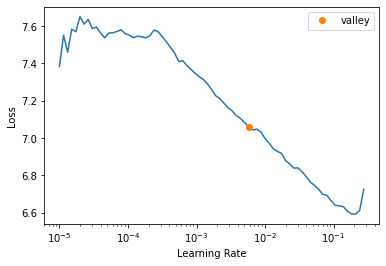

In [70]:
learn_bnb.lr_find(start_lr=1e-05)

In [71]:
learn_bnb.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,5.289897,None,00:01
1,4.893563,None,00:01
2,4.758530,None,00:01
3,4.708583,None,00:01
4,4.628142,None,00:01


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [72]:
learn_bnb.export('models/learn_bnb.pkl')

In [73]:
to.export('models/to.pkl')

### t-SNE

In [83]:
df['HomeTeam'].astype('category').cat.categories.values

array(['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta',
       'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona',
       'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum',
       'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari',
       'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone',
       'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt',
       'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina',
       'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa',
       'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp',
       'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca',
       'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes',
       'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool',
       'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City',
       'Man United'

In [84]:
df['AwayTeam'].astype('category').cat.categories.values

array(['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta',
       'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona',
       'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum',
       'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari',
       'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone',
       'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt',
       'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina',
       'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa',
       'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp',
       'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca',
       'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes',
       'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool',
       'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City',
       'Man United'

In [85]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 129
['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona', 'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum', 'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari', 'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone', 'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt', 'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina', 'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa', 'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp', 'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes', 'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool', 'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City', 'Man United', 'Marseille', 'Metz', 'Milan', 'Monaco', 'Montpellier', 'Nantes', 'Napoli', 'Newc

In [86]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

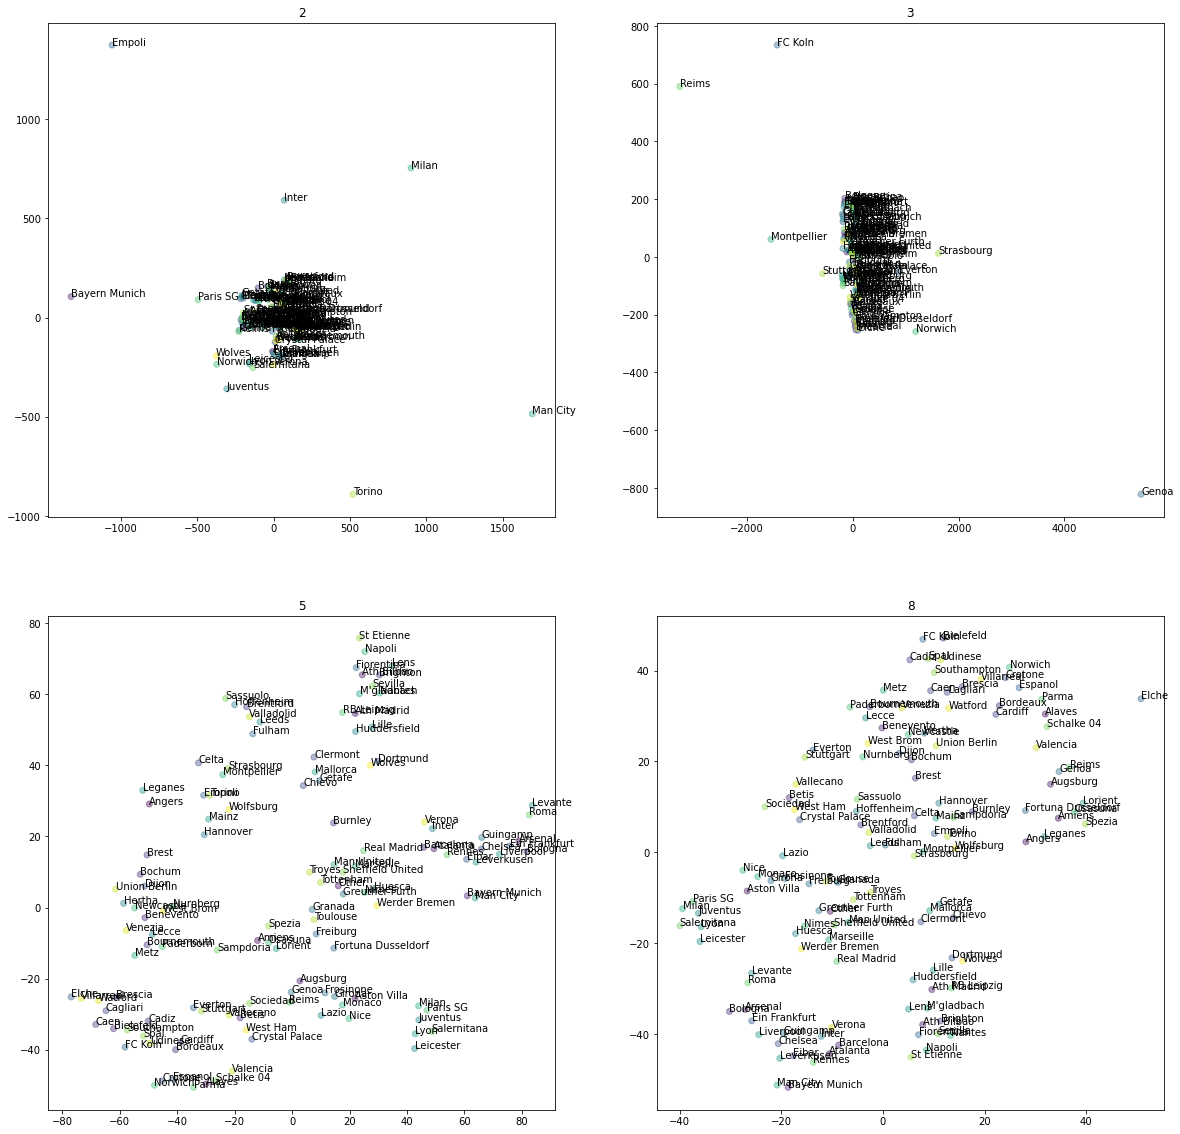

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END